In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

import os
os.chdir("..")

# Import relevant packages
from src.eda import data_info
from src.explainability import *

# Import necessary libraries
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import wilcoxon
import numpy as np
from itertools import combinations

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'  # or other, 'dejavuserif'
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' serif' 'Times'
plt.rcParams['font.size'] = 9

In [2]:
# Chosen tuning objective
metric = "AUC"
x_size = 12000
explain_size = 500

"""for script in ["explain", "explain_eval"]:

    # Create the script directory if it doesn't exist
    os.makedirs("scripts", exist_ok=True)
    with open(f"scripts/{script}.sh", "w") as f:
        f.write("#!/bin/bash\n")

    # Create .sh file:
    for model_type in ["baseline", "dpsgd"]:
        if model_type == "baseline":
            n_line = x_size // explain_size + 1
        else:
            n_line = (x_size // explain_size + 1) * 3

        for i in range(n_line): 
            txt = f'python3.11 "scripts/{script}.py" --metric {metric}'
            if i > 0:
                txt += f' --continue_run True'
            if model_type == "dpsgd":
                txt += f' --model_type {model_type}'
            with open(f"scripts/{script}.sh", "a") as f:
                f.write(txt + "\n")"""

'for script in ["explain", "explain_eval"]:\n\n    # Create the script directory if it doesn\'t exist\n    os.makedirs("scripts", exist_ok=True)\n    with open(f"scripts/{script}.sh", "w") as f:\n        f.write("#!/bin/bash\n")\n\n    # Create .sh file:\n    for model_type in ["baseline", "dpsgd"]:\n        if model_type == "baseline":\n            n_line = x_size // explain_size + 1\n        else:\n            n_line = (x_size // explain_size + 1) * 3\n\n        for i in range(n_line): \n            txt = f\'python3.11 "scripts/{script}.py" --metric {metric}\'\n            if i > 0:\n                txt += f\' --continue_run True\'\n            if model_type == "dpsgd":\n                txt += f\' --model_type {model_type}\'\n            with open(f"scripts/{script}.sh", "a") as f:\n                f.write(txt + "\n")'

In [3]:
shap_dict = {}

for model_type in ["baseline", "dpsgd"]:
    # Initialize the SHAP explainer
    shap_init = ShapKernelExplainer(model_type=model_type, metric=metric)
    # Get the model version and predictions
    for i, row in shap_init.model_info.iterrows():
        version = row["version"]
        try:
            explanation = pd.read_feather(f"results/explainability/{model_type}/{version}_fixed.feather").values
        except FileNotFoundError:
            explanation = []
        if model_type == "baseline":
            eps = None
        else:
            eps = row['epsilon']
        shap_dict[(model_type, version, eps)] = explanation

X_test = shap_init.X_test.values
all_cols = shap_init.all_cols

## 1. Visualize the SHAP values

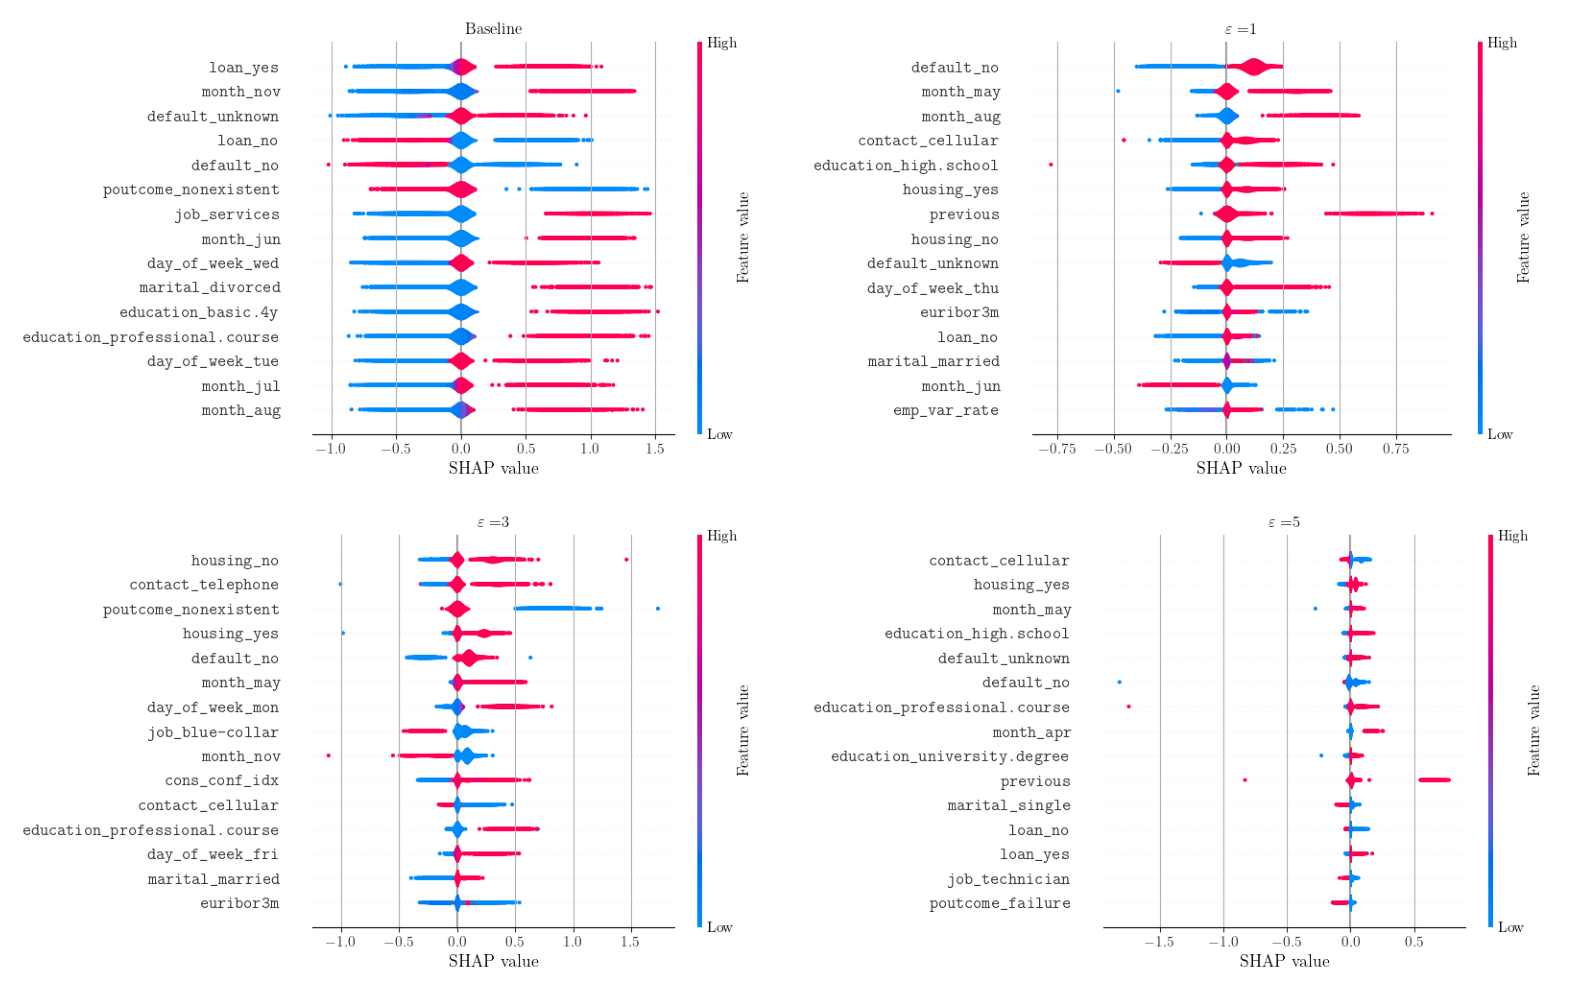

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2 rows x 2 cols
# Flatten the axes array for easier indexing
axes = axes.flatten()
j = 0

for (model_type, version, eps), explanation in shap_dict.items():
    # Get the model predictions
    y_pred = pd.read_feather(f"experiments/predictions/{model_type}/{version}_pred.feather")
    # Get the input of anomalies
    #x_anomaly = shap_init.X_test[y_pred['anomaly']==1].values
    # Get the SHAP values
    if explanation == []:
        continue
    else:
        shap_values = explanation
    # Plot the SHAP values
    if model_type == "baseline":
        title = "Baseline"
    else:
        title = r"$\varepsilon =$" + f"{eps:.0f}"
    # Create a temporary figure
    temp_fig = plt.figure()
    shap.summary_plot(shap_values,
                features=X_test,
                feature_names=[f"\\texttt{{{col}}}" for col in all_cols],
                show=False,
                plot_size=(8, 5),
                max_display=15,
                plot_type="violin",
                title=title,
                )
    # Draw the canvas, copy contents, and close temp
    temp_fig.canvas.draw()
    image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(temp_fig)

    # Show the image in the target subplot
    axes[j].imshow(image)
    axes[j].axis("off")
    j += 1

plt.tight_layout()
plt.savefig(f"results/figures/shap_values.png", bbox_inches='tight', dpi=300)
plt.show()

## 2. SHAPGap

SHAPGap-euclidean for dpsgd with epsilon 1.0: 1.8810, 0.6529
SHAPGap-cosine for dpsgd with epsilon 1.0: 0.8946, 0.2949
SHAPGap-euclidean for dpsgd with epsilon 3.0: 1.8845, 0.6149
SHAPGap-cosine for dpsgd with epsilon 3.0: 0.8472, 0.2576
SHAPGap-euclidean for dpsgd with epsilon 5.0: 1.8596, 0.7208
SHAPGap-cosine for dpsgd with epsilon 5.0: 0.8049, 0.2952


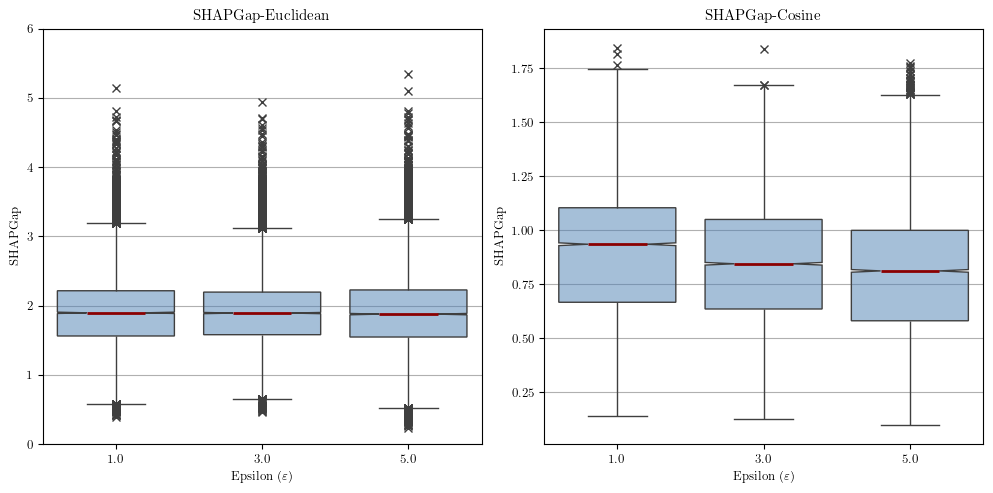

In [5]:
# Plot the SHAP values for the baseline and DPSGD models
records = []

for (model_type, version, eps), explanation in shap_dict.items():
    if model_type == "baseline":
        baseline_explanation = explanation

for (model_type, version, eps), explanation in shap_dict.items():
    if model_type == "dpsgd":
        dpsgd_explanation = explanation
        for gap_type in ["euclidean", "cosine"]:
            if gap_type == "euclidean":
                baseline_explanation_norm = normalize_shap(baseline_explanation, method="zscore")
                dpsgd_explanation_norm = normalize_shap(dpsgd_explanation, method="zscore")
            else:
                baseline_explanation_norm = normalize_shap(baseline_explanation, method="l2")
                dpsgd_explanation_norm = normalize_shap(dpsgd_explanation, method="l2")
            gap = shap_gap(baseline_explanation, dpsgd_explanation, gap_type=gap_type)
            print(f"SHAPGap-{gap_type} for {model_type} with epsilon {eps}: {np.mean(gap):.4f}, {np.std(gap):.4f}")
            records.append({
                "epsilon": eps,
                "gap_type": gap_type,
                "shap_gap": gap
            })

# Convert to DataFrame for seaborn
df = pd.DataFrame(records)

# Explode the 'shap_gap' column so that each list item becomes a row
df_melted = df.explode("shap_gap").reset_index(drop=True)

# Convert shapgap values to float (they may be stored as objects/strings)
df_melted["shap_gap"] = df_melted["shap_gap"].astype(float)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot each gap type
for i, gap_type in enumerate(["euclidean", "cosine"]):
    sns.boxplot(data=df_melted[df_melted["gap_type"] == gap_type], x="epsilon", y="shap_gap", ax=axes[i],
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.3, .5, .7, .5)},
                medianprops={"color": "darkred", "linewidth": 2},
                notch=True, showcaps=True)
    axes[i].set_title(f"SHAPGap-{gap_type.capitalize()}")
    axes[i].set_xlabel(r"Epsilon ($\varepsilon$)")
    axes[i].set_ylabel("SHAPGap")
    axes[i].grid(axis='y')
    if gap_type == "euclidean":
        axes[i].set_ylim(0, 6)

plt.tight_layout()
plt.savefig(f"results/figures/shap_gap.png", bbox_inches='tight', dpi=300)
plt.show()

In [6]:
df_melted.groupby(["gap_type", "epsilon"]).agg(["mean", "std", "median", "min", "max"])

shap_gap                                         
                       mean       std    median       min        max
gap_type  epsilon                                                   
cosine    1.0      0.894596  0.294950  0.935695  0.141011   1.845860
          3.0      0.847166  0.257564  0.845267  0.125984   1.841354
          5.0      0.804898  0.295166  0.812254  0.097505   1.772721
euclidean 1.0      1.881001  0.652978  1.897310  0.390636   7.561248
          3.0      1.884549  0.614945  1.893634  0.463774  10.044880
          5.0      1.859633  0.720875  1.878270  0.237326  10.550120

## 3. Infidelity, Sensitivity, and AOPC

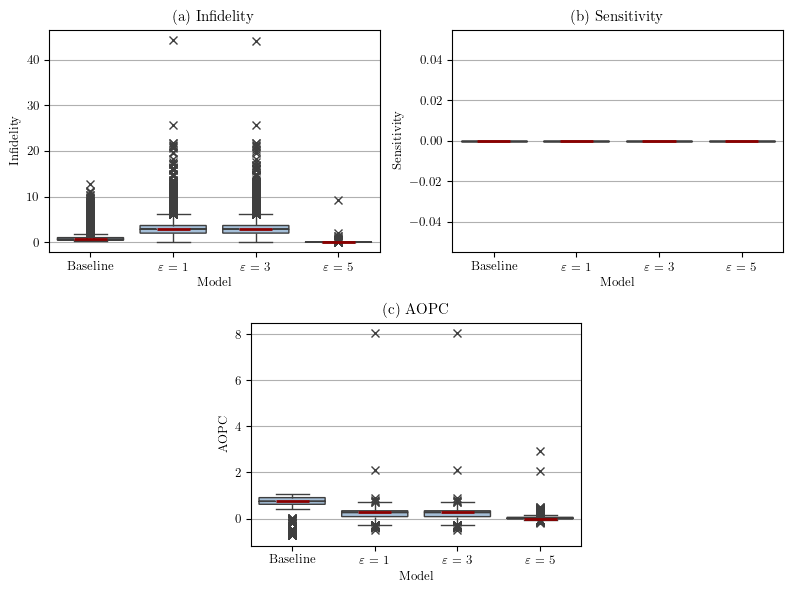

In [7]:
# Create figure and define the grid layout
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1])
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1, :])

# First plot: Infidelity
ax1 = fig.add_subplot(gs[0, 0:2])  # Top-left

# Second plot: Sensitivity
ax2 = fig.add_subplot(gs[0, 2:4])  # Top-right

# Third plot: AOPC
ax3 = fig.add_subplot(gs_bottom[0, 1:3])  # Center cell of the 4-column row

df = pd.DataFrame(columns=["model", "infidelity", "sensitivity", "aopc"])
# Plot the metrics for the baseline and DPSGD models
for (model_type, version, eps), explanation in shap_dict.items():
    try:
        # Get the explainability metrics
        perf_metrics = pd.read_feather(f"results/explainability/{model_type}/{version}_fixed_eval.feather")
        perf_metrics["model"] = model_type.capitalize() if model_type == "baseline" else r"$\varepsilon$" + f" = {eps:.0f}"

        # Append the metrics to the DataFrame
        df = pd.concat([df, perf_metrics], ignore_index=True)
    except FileNotFoundError:
        print(f"File not found for {model_type} with version {version}")

df.fillna(0, inplace=True)

sns.boxplot(data=df,
            x="model",
            y="infidelity",
            ax=ax1,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "darkred", "linewidth": 2},
            notch=True, showcaps=True)

sns.boxplot(data=df,
            x="model",
            y="sensitivity",
            ax=ax2,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "darkred", "linewidth": 2},
            notch=True, showcaps=True)

sns.boxplot(data=df,
            x="model",
            y="aopc",
            ax=ax3,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "darkred", "linewidth": 2},
            notch=True, showcaps=True)

# Set the titles for the subplots
ax1.set_title("(a) Infidelity")
ax2.set_title("(b) Sensitivity")
ax3.set_title("(c) AOPC")

# Set the y-axis labels
ax1.set_ylabel("Infidelity")
ax2.set_ylabel("Sensitivity")
ax3.set_ylabel("AOPC")

# Set the y-axis labels
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("Model")
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

In [8]:
df.melt(id_vars=["model"], value_vars=["infidelity", "sensitivity", "aopc"], var_name="metric", value_name="value").groupby(["metric", "model"]).agg(["mean", "std", "median", "min", "max"])

value                                    \
                                   mean       std        median       min   
metric      model                                                           
aopc        $\varepsilon$ = 1  0.217879  0.191309  2.636362e-01 -0.475910   
            $\varepsilon$ = 3  0.217845  0.191313  2.636141e-01 -0.475910   
            $\varepsilon$ = 5  0.029742  0.070992  1.192093e-07 -0.171723   
            Baseline           0.645944  0.367280  7.474044e-01 -0.734197   
infidelity  $\varepsilon$ = 1  3.027076  1.718302  2.855029e+00  0.017568   
            $\varepsilon$ = 3  3.028080  1.718720  2.851155e+00  0.016302   
            $\varepsilon$ = 5  0.029706  0.096610  1.812533e-02  0.001193   
            Baseline           0.913835  0.905100  6.117008e-01  0.170334   
sensitivity $\varepsilon$ = 1  0.000000  0.000000  0.000000e+00  0.000000   
            $\varepsilon$ = 3  0.000000  0.000000  0.000000e+00  0.000000   
            $\varepsilon$ = 5  0.000000  0.000000  0.000000e+00  0.000000   
            Baseline           0.000000  0.000000  0.000000e+00  0.000000   

                                          
                                     max  
metric      model                         
aopc        $\varepsilon$ = 1   8.060616  
            $\varepsilon$ = 3   8.060616  
            $\varepsilon$ = 5   2.936008  
            Baseline            1.052163  
infidelity  $\varepsilon$ = 1  44.431080  
            $\varepsilon$ = 3  44.176571  
            $\varepsilon$ = 5   9.208815  
            Baseline           12.780806  
sensitivity $\varepsilon$ = 1   0.000000  
            $\varepsilon$ = 3   0.000000  
            $\varepsilon$ = 5   0.000000  
            Baseline            0.000000

In [9]:
def run_pairwise_wilcoxon(df, metric_col='aopc'):
    # List all model names
    models = df.model.unique()

    pivot_df = pd.DataFrame()
    
    for model in models:
        model_df = df[df['model'] == model][[metric_col]].reset_index(drop=True).rename(columns={metric_col: f"{model}"})
        pivot_df = pd.concat([pivot_df, model_df], axis=1)

    table = pd.DataFrame(index=models, columns=models)

    for m1, m2 in combinations(models, 2):
        stat, p = wilcoxon(pivot_df[m1], pivot_df[m2])
        # Fill symmetric entries
        table.loc[m1, m2] = f"p = {p:.4g}"
        table.loc[m2, m1] = f"p = {p:.4g}"

    # Fill diagonal with dashes or 1.000
    for m in models:
        table.loc[m, m] = "—"

    return table

run_pairwise_wilcoxon(df, metric_col='aopc')

,Baseline,$\varepsilon$ = 1,$\varepsilon$ = 3,$\varepsilon$ = 5
Baseline,—,p = 0,p = 0,p = 0
$\varepsilon$ = 1,p = 0,—,p = 0.9584,p = 0
$\varepsilon$ = 3,p = 0,p = 0.9584,—,p = 0
$\varepsilon$ = 5,p = 0,p = 0,p = 0,—
